# Test model for some dastardly errors

A simplified version of the subduction wedge. 

### Problems in serial

Using Q1 elements:

* This model will run at resolutions 32, 64, 128, if the mg levels are the default ones
* It fails at 48, 96 no matter what the mg levels are set to

Using Q2 elements

* The models fails under all Resolution / mg level combinations tested

### Problems in parallel

In parallel, a separate error appears when the Q22 preconditioner is set to anything other than the default `uw`


In [117]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer
from mpi4py import MPI
import operator

In [118]:
res = 128
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

stressField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=3 )


In [119]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
stressField.data[...] = (0.0,0.0,0.0)

In [120]:
nodesInGrid = np.arange(mesh.nodesGlobal).reshape(mesh.elementRes[0] + 1,mesh.elementRes[0] + 1)
checkerNodes = nodesInGrid[::2, 1::2]
specialNodes = np.setdiff1d(nodesInGrid.flatten(), checkerNodes.flatten())

In [121]:
#nodes = np.where( mesh.data[:,1] < 1e-3 + (1. - mesh.data[:,0])  )[0]
nodes0 = np.where(operator.and_(mesh.data[:,1] < 1e-3 + (1. - mesh.data[:,0]), 
                               mesh.data[:,1] > -1. + (1. - mesh.data[:,0])))[0]


nodes = np.intersect1d(nodes0, checkerNodes) #if you use the 'checker' nodes. this solution works in parallel

drivenVelNodes = mesh.specialSets["Empty"]
drivenVelNodes.add(nodes)

In [122]:
velocityField.data[nodes]= np.sqrt(0.5), -1.*np.sqrt(0.5)


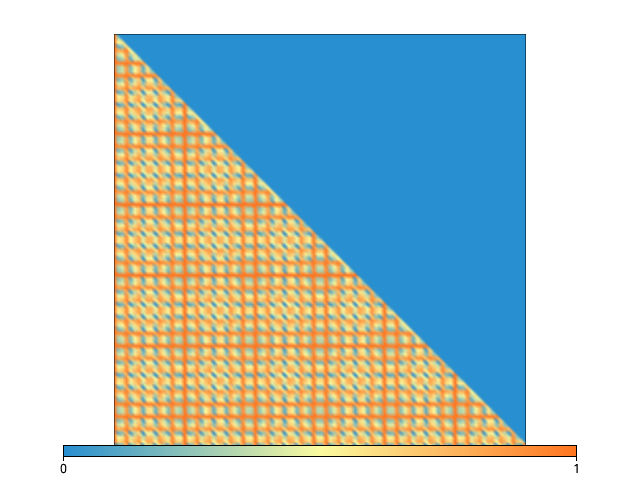

In [123]:
#fig= glucifer.Figure(quality=3)
#fig.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField, velocityField)))
#fig.show()
#fig.save_database('test0.gldb')

In [124]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]
rWalls = mesh.specialSets["MaxI_VertexSet"]
      

Populating the interactive namespace from numpy and matplotlib


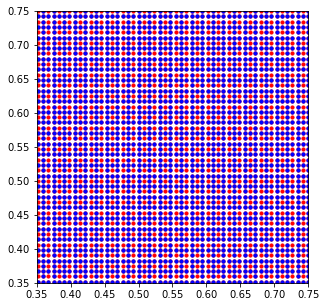

In [93]:

try:
    %pylab inline
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(mesh.data[:,0], mesh.data[:,1],s = 10, c = 'r')
    ax.scatter(mesh.data[specialNodes,0], mesh.data[specialNodes,1],s = 10., c ='b')


    #neumannNodes0 = rWalls - tWalls - bWalls 
    #neumannNodes1 = lWalls + bWalls - drivenVelNodes
    #neumannNodes = neumannNodes0 + neumannNodes1

    dirichNodes = drivenVelNodes + tWalls

    #ax.scatter(mesh.data[neumannNodes.data][:,0], mesh.data[neumannNodes.data][:,1],s = 10)
    #ax.scatter(mesh.data[dirichNodes.data][:,0], mesh.data[dirichNodes.data][:,1],s = 10)

    #ax.scatter(fault.swarm.particleCoordinates.data[:,0], fault.swarm.particleCoordinates.data[:,1],s = 30)


    ax.set_aspect('equal')
    ax.set_ylim(0.35, 0.75)
    ax.set_xlim(0.35, 0.75)
except:
    pass

In [94]:
#Stokes BCs


#Neumann on RHS nodes minus the bottom and top node 
velNbc = uw.conditions.NeumannCondition( flux=stressField, 
                                      variable=velocityField,
                                      nodeIndexSet=(rWalls - tWalls - bWalls ) )


#Dirichlet conditions on nodes including and beneath the main diagonal, as well as topWalls
velDbc = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( tWalls + drivenVelNodes,  tWalls + drivenVelNodes) )

In [95]:
stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velDbc,velNbc],
                                   fn_viscosity   = 1., 
                                   fn_bodyforce   = (0., 0.) )

In [96]:
solver = uw.systems.Solver(stokesPIC)


In [97]:
solver.set_inner_method('mg')
#solver.set_inner_method('mumps')

solver.options.main.Q22_pc_type='gkgdiag'   #This should cause problems in parallel, regardless of inner method used
solver.options.mg.levels = 4                #this should cause problem in serial, if not equal to the default number


In [98]:
#solver.options.mg.levels, solver.options.scr.ksp_rtol, solver.get_stats()

In [99]:
solver.solve()

In [100]:
fig= glucifer.Figure(quality=3)

fig.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField, velocityField)))
#fig.append( glucifer.objects.Surface(mesh, 
#                                     fn.tensor.second_invariant(fn.tensor.symmetric(velocityField.fn_gradient)))
                                                                     
#                                                                     )

fig.append( glucifer.objects.VectorArrows(mesh, velocityField*0.07))


#fig.show()



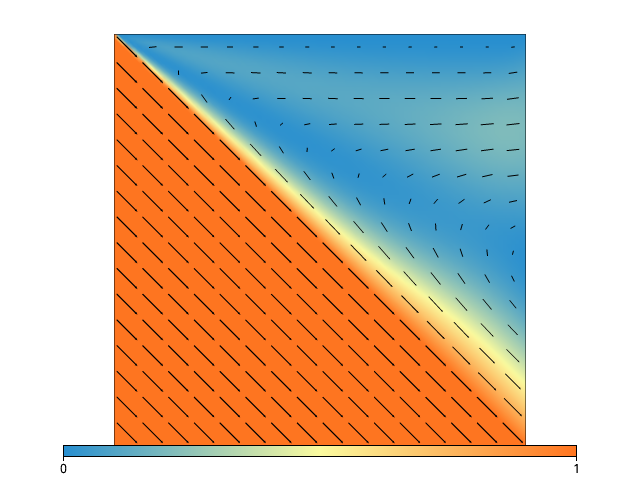

'test.gldb'

In [101]:
fig.show()
fig.save_database('test.gldb')